# Density-functional theory (DFT) for periodic problems


## Lattices and periodic problems

### The Bloch transform

- Consider a 1D periodic **lattice** with lattice constant $a$:
  ```
    |-------|-------|-------|
        a       a       a
  ```
- We take its **unit cell** as the interval $A = [-a/2, a/2)$
- Consider free-electron Hamiltonian
  $$ H = -\frac12 \Delta $$
  seeking its eigenfunctions $ H \psi_i = \varepsilon_i \psi_i $
  

- Perodicity of the problem implies that the Hamiltonian commutes with lattice translations $T_{n a}$
  $$ T_{n a} H = H T_{n a} \qquad \forall n \in \mathbb{Z}$$
- In this case **Bloch's theorem** says the solution has the form $ \psi = e^{i k \cdot x} u_k(x) $
  where $u_k(x)$ has the perodicity of the lattice
  $$ u_k(x + na) = u_k(x) \qquad \forall n \in \mathbb{Z}$$
  and is indexed in a real number $k$.
- Apply $-\Delta = -\frac{d^2}{dx^2}$ to this ansatz:
  $$
    -\Delta \left(e^{i k \cdot x} u_k(x)\right) = (k^2 - 2ik \nabla - \Delta) ) e^{i k \cdot x} u_k(x) = (-i \nabla + k)^2 e^{i k \cdot x} u_k
  $$
- With this in mind it is natural to define a family
  $$ H_k = \frac12 (-i \nabla + k)^2 $$
  as pendants to $H$.

- In fact one can find a unitary transformation $U$ (the **Bloch transform**) such that for any $k$:
$$ (U H U^{-1}) \psi_k = H_k \psi_k $$
where $\psi_k$ are eigenfunctions of $H_k$.
- This implies for $\sigma(H)$, the set of eigenvalues of $H$:
$$ \sigma(H) = \bigcup_k \sigma(H_k) $$

**Remark:** Since the spectrum of the Hamiltonian has direct physical significance (think about the eigenvalues of the Fock matrix in Hartree-Fock theory or Kohn-Sham matrix in density-functional theory), this tells us that we never need to bother with the full operator, but instead can only consider the family $\{H_k\}_k$. This is of advantage in practice since the dimension of the domains of the respective operators is much smaller and additionally computing the eigenpairs of the $H_k$s instead of the $H$ allows to obtain (a) a better physical understanding and (b) numerical answers in better agreement with physics.

### The Brillouin zone

The big mystery in the discussion so far is the parameter $k$ of the operator families.

- In principle $k$ can take *any* real value. It turns out, however, that some of these values will give rise
  to operators related by unitary transformations
- Since such operators have the same eigenspectrum, only one version needs to be considered.
- The smallest subset from which $k$ is chosen is the **Brillouin zone** (BZ).


- The BZ is the unit cell of the **reciprocal lattice**, which may be constructed from the **real-space lattice**
  by a Fourier transform.
- In our simple 1D case the reciprocal lattice is just
  ```
    |--------|--------|--------|
       2π/a     2π/a     2π/a
  ```
  i.e. like the real-space lattice, but just with a different lattice constant $b = 2\pi / a$.
- The BZ in this example is $B = [-2π/a, 2π/a)$

### Discretising the problem

- We just need to find the eigenspectrum of all $H_k$ with $k \in B$ and then we have solved the free-electron on a 1D lattice.
- Problem 1: $B$ is an overcountable set
- Problem 2: The domain of $H_k$ is infinite dimensional, but our computer only has finite memory.

- Solution 1: **$k$-point sampling**. Instead of considering the full Brillouin zone we just consider a regular grid of values for $k$, the so-called **$k$-points**.
- Solution 2: We don't compute the eigenvalues of $H_k$, but only the eigenvalues of $H_k$ in a finite-sized basis (Galerkin method).

### Plane-wave basis sets

Multiple basis sets are used in practice. One basis set agreeing particularly well with the nature of periodic problems
are plane waves. For our 1D example normalised plane waves are defined as the functions
$$ e_{G}(x) = \frac{e^{i G x}}{\sqrt{a}}  \qquad G \in b\mathbb{Z} $$
and typically one forms basis sets from these by specifying a so-called **kinetic energy cutoff** $E_\text{cut}$:
$$ \left\{ e_{G} \, \big| \, (G + k)^2 \leq 2E_\text{cut} \right\} $$

Notice that (our) $H_k$ is already diagonal with this basis:
\begin{align}
\langle e_{G} | H_k e_{G'} \rangle
&=  \frac12 \left\langle e_{G} \middle| (-i \nabla + k)^2 \, e_{G'} \right\rangle \\
&= \frac12 (G + k)^2 \left\langle e_{G} \middle|e_{G'}\right\rangle \\
&= \frac12 (G + k)^2 \delta_{GG'}
\end{align}

### A numerical example 
Enough theory ... let's see some Julia code and plot some pictures!

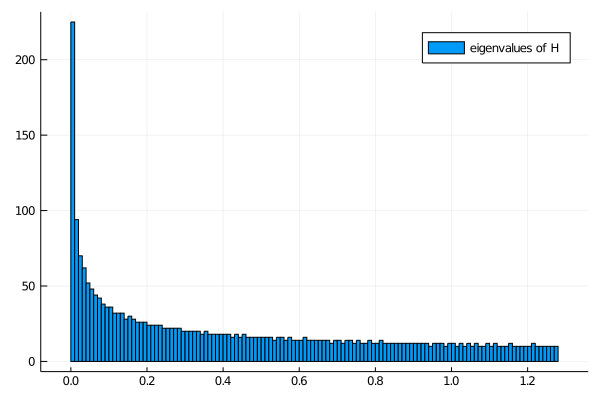

In [1]:
using LinearAlgebra
using Plots

# Paramaters
a = 100     # Lattice constant
Ecut = 300  # in Hartree
kgrid = 50  # Number of points on equally-spaced grid for k

# Derived quantities
b = 2π / a
kpoints = b * (collect(1:kgrid) .- ceil(Int, kgrid / 2)) ./ kgrid
Gmax = ceil(Int, sqrt(2Ecut) + b)

# One array of all valid G*b per kpoint
Gs = [[Gidx*b for Gidx in -Gmax:Gmax if abs2(Gidx*b + k) ≤ 2Ecut]
      for k in kpoints]

# Build the diagonal elements (== eigenvalues) of the Hk per kpoint
# and sort them ascendingly
ev_Hk = [sort([abs2(G + k)/2 for G in Gs[ik]])
         for (ik, k) in enumerate(kpoints)]

# Build the eigenvalues of H, by combining and sorting the ev_Hk
ev_H = sort(vcat(ev_Hk...))

histogram(ev_H, label="eigenvalues of H", bins=minimum(ev_H):0.01:maximum(ev_H))

What this plot shows us is that $H$ has pretty much a continuous spectrum. A more instructive way to see this is plot a so-called band structure, i.e. to plot the eigenvalues versus $k$.

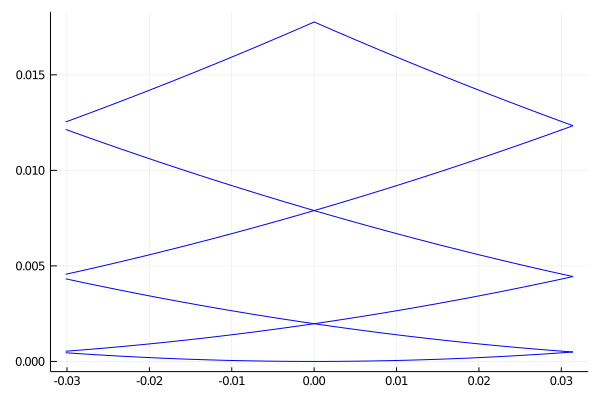

In [2]:
# Plot bands
n_bands = 6
bands = [[ev_Hk[ik][iband] for ik in 1:length(kpoints)]
         for iband in 1:n_bands]

p = plot()
for iband in 1:n_bands
    plot!(p, kpoints, bands[iband], color=:blue, label="")
end
p

## Going to 3D

- Our example: Silicon

| <img src="img/Silicon_crystal.jpg" width=180 height=180 /> |
| --------------- |
| silicon crystal |

- $A$ becomes a matrix, e.g. for silicon (diamond structure)
  $$ A = \frac{a}{2} \left( \begin{array}{ccc} 0&1&1\\1&0&1\\1&1&0 \end{array} \right) \qquad a = 10.26\,\text{bohr}. $$
- Brillouin zones become more involved:

| <img src="img/Brillouin_Zone.svg" width=250 height=250 /> |
| --------------------------------------------------------- |
|   face-centred cubic BZ (applies to silicon)              |
  
- $k$-points are vectors taken from a rectangular 3D grid inside the BZ
- Plane-wave wave vectors $G$ are vectorial:
  $$ e_G = \frac{1}{\sqrt{\text{det}(A)}} e^{i G\cdot r} $$
- Cutoff taken over norm:
  $$ \{ e_G | \|G + k\| \leq E_\text{cut} \} $$
- A small cut throught the silicon lattice:

In [3]:
using PyCall
using LinearAlgebra
silicon = pyimport("ase.build").bulk("Si")
silicon = pyimport("ase.build").make_supercell(silicon, Matrix(Diagonal([3, 3, 3])))
silicon.write("img/silicon.png")

<img src="img/silicon.png" width=250 height=250 />

- The bandstructure of silicon:
<img src="img/silicon_bands.png" width=600 height=600 />

## DFT for periodic problems

### Density matrix for periodic problems

- Periodic Hamiltonian $H = -\frac12 \Delta + V$ where $V$ is for example the potential of a periodic Kohn-Sham model.
- Related $k$-point-specific family of operators
  $$H_k = \frac12 (-i\nabla + k)^2 + V$$
  with eigendecomposition $\{(\varepsilon_{ki}, \psi_{ki})\}_{ki}$, i.e.
  $$H_k \psi_{ki} = \varepsilon_{ki} \psi_{ki}$$
  
  
- Using the **characteristic function**
  $$ \mathbb{1}_S(x) = \left\{\begin{array}{ll} 1 & x \in S \\ 0 & \text{else} \end{array}\right. $$
  we can define the $N$-electron **density matrix** $\gamma$ corresponding to $H$ for the zero-temperature case:
  $$\begin{align}
  \gamma(r, r') &= \left[\mathbb{1}_{(-\infty, \varepsilon_F)}\left(H \right)\right](r, r') \\
                &= \sum_{k\in\text{BZ}} \left[\mathbb{1}_{(-\infty, \varepsilon_F)}\left(H_k \right)\right](r, r') \\
                &= \sum_{k\in\text{BZ}} \sum_{i} \mathbb{1}_{(-\infty, \varepsilon_F)}(\varepsilon_{ki})\, \psi_{ki}(r)\, \psi_{ki}^\ast(r') \\
                &= \sum_{k\in\text{BZ}} \sum_{\varepsilon_{ki} \leq \varepsilon_F}\, \psi_{ki}(r)\, \psi_{ki}^\ast(r') \\
  \end{align}$$
  where the **Fermi level** $\varepsilon_F$ is chosen such that $\text{tr}(\gamma) = N$.
  
  
- This is the picture for zero temperature and without spin.
- For **finite temperature**, instead we need to weigh the states by their occupation
  according to the **Fermi-Dirac distribution**
  $$ f_{\varepsilon_F}(x) = \frac{1}{1 + \exp\left(\frac{x - \varepsilon_F}{T}\right)}$$
  at temperature $T$. This results in the expression
  $$\gamma(r, r') = f_{\varepsilon_F}(H) = \sum_{k\in\text{BZ}} \sum_i f_{\varepsilon_F}(\varepsilon_{ki}) \, \psi_{ki}(r) \, \psi_{ki}^\ast(r').$$

### DFT in the density-matrix formalism
The key equation of DFT is to find the minimising density matrix
  $$ \gamma_0 = \text{argmin}_{\gamma\in\mathcal{P}_N} \mathcal{E}_\text{DFT}(\gamma) $$
where:

- $\mathcal{P}_N$ is the set of all admissible **density matrices**
  for a system of $N$ electrons
- DFT **energy functional** 
  \begin{align*}
    \mathcal{E}_\text{DFT}(\gamma) &= \text{tr}_{L^2}\left( - \frac12 \Delta \gamma \right) + \int \rho_\gamma(r)\,V_\text{Nuc}(r) \ dr\\
    &+ \frac12 \int \frac{\rho_\gamma(r)\,\rho_\gamma(r')}{|r - r'|} dr\,dr'
    + E_\text{xc}(\rho_\gamma)
  \end{align*}
- **Density** $\rho_\gamma(r) = \gamma(r, r)$ 
- **Exchange-correlation functional** $E_\text{xc}$
- The trace of the Laplacian with the density matrix can be understood as
$$ \text{tr}_{L^2}\left( - \frac12 \Delta \gamma \right)
   = -\frac12 \sum_{ki} f_{\varepsilon_F}(\varepsilon_{ki}) \, \langle \psi_{ki} | \Delta \psi_{ki} \rangle. $$
   
- Nuclear potential $V_\text{Nuc}$: Usually a pseudopotential:
  * Only valence electrons treated
  * Smoothening near nuclei (avoid electron-nuclear cusp)

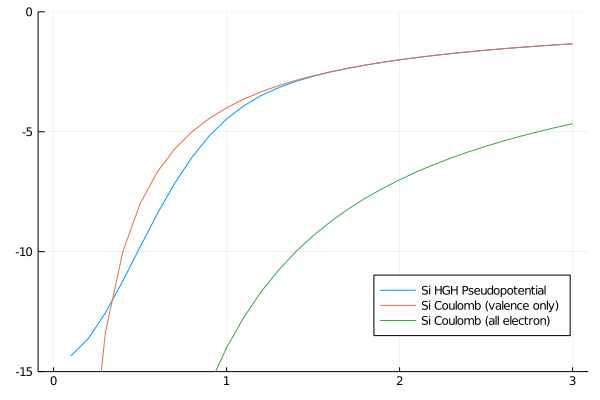

In [26]:
using DFTK
using Plots

# Pseudopotential treatment, valence charge 4
SiPseudo = ElementPsp(:Si, psp=load_psp("hgh/lda/Si-q4"))

# All-electron treatment, valence charge 14
SiCoulomb = ElementCoulomb(:Si)

rs = collect(0:0.1:3)
p = plot(ylims=(-15, 0), legend=:bottomright)
plot!(p, rs, DFTK.local_potential_real.(Ref(SiPseudo), rs), label="Si HGH Pseudopotential")
plot!(p, rs, -4 ./ abs.(rs), label="Si Coulomb (valence only)")
plot!(p, rs, DFTK.local_potential_real.(Ref(SiCoulomb), rs), label="Si Coulomb (all electron)")

### SCF procedure
At stationarity the following Euler-Lagrange equations are satisfied
$$
\left\{\begin{aligned}
    \gamma_0
    &= \mathbb{1}_{(-\infty, \varepsilon_F)}
       \left(-\frac12 \Delta + V_{\gamma_0} \right)
       \quad
       \text{with $\varepsilon_F$ s.t. $\gamma_0 \in \mathcal{P}_N$} \\
    V_\gamma(r)
    &= V_\text{Nuc}(r) + \int \frac{\rho_\gamma(r')}{|r - r'|} dr'
       + V_{\text{xc},\rho_\gamma}(r), \\
    \rho_\gamma(r)
    &= \gamma(r, r), \gamma \in \mathcal{P}_N \\
\end{aligned}\right.
$$
with the **exchange-correlation potential** $V_{\text{xc},\rho_\gamma}$,
which is the derivative of the exchange-correlation energy functional wrt. the density.

This naturally leads to the **SCF procedure** as a way to solve these:
1. Guess initial $\rho_\gamma$
1. Build Kohn-Sham Hamliltonians $H_k = \frac12 (-i \nabla + k)^2 + V_\gamma$
   at all $k$ points
1. Diagonalise them to get $(\varepsilon_{k i}, \psi_{ki})$
1. Build new $\rho_\gamma$, go to 2.

### Computing a band structure

As an overview of a plane-wave DFT calculation we will show how to compute the bands of silicon in DFTK.

Input parameters:
- Lattice and structure of silicon lattice
- Definition of the DFT model (here LDA)
- Discretisation: $E_\text{cut} = 15$ for the plane-wave basis and $k$-point grid with 4 $k$-points in each space dimension in the BZ

In [5]:
a = 10.26  # Silicon lattice constant in Bohr
lattice = a / 2 * [[0 1 1.];
                   [1 0 1.];
                   [1 1 0.]]
Si = ElementPsp(:Si, psp=load_psp("hgh/lda/Si-q4"))
atoms = [Si => [ones(3)/8, -ones(3)/8]]

model = model_LDA(lattice, atoms)  # A simple DFT model
Ecut = 15                          # Energy cutoff in Hartree
basis = PlaneWaveBasis(model, Ecut; kgrid=[4, 4, 4]);

First step is to run the SCF to get the minimising density $\rho_{\gamma_0}$.

In [6]:
scfres = self_consistent_field(basis, tol=1e-8);

n     Energy            ρout-ρin   Eₙ₋₁-Eₙ    Diag
---   ---------------   --------   --------   ----
1     -7.919462763521   2.04e-01        NaN   4.3 
2     -7.924129076551   2.94e-02   4.67e-03   1.0 
3     -7.924824826332   5.31e-03   6.96e-04   1.4 
4     -7.924884588281   1.01e-03   5.98e-05   2.3 
5     -7.924885166026   5.92e-04   5.78e-07   1.8 
6     -7.924885221915   3.33e-05   5.59e-08   1.0 
7     -7.924885229040   1.45e-05   7.13e-09   2.8 


With the ground state found, further properties can be computed, for example the bandstructure.
As before we diagonalise multiple $H_k$ at a finer $k$-point mesh:

Computing bands along kpath:
       Γ -> X -> W -> K -> Γ -> L -> U -> W -> L -> K  and  U -> X


Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:06


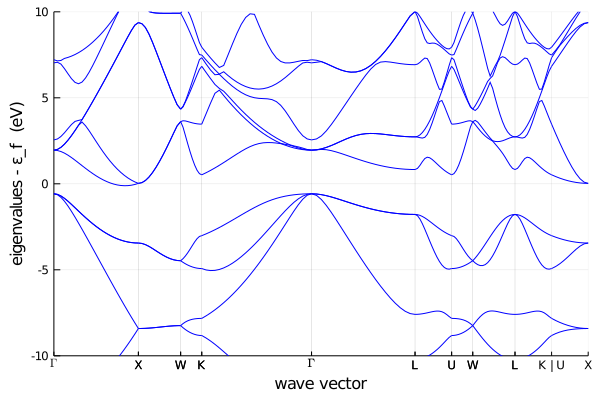

In [7]:
n_bands = 10
p = plot_bandstructure(scfres, n_bands)
savefig(p, "img/silicon_bands.png")
p